In [15]:
# Core libraries
import numpy as np
import pandas as pd
import os

# Machine learning
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.inspection import permutation_importance

# Hyperparameter tuning
import optuna
# 1) Silence Optuna’s default trial‐completion logs
optuna.logging.set_verbosity(optuna.logging.WARNING)      # only WARN and above
optuna.logging.disable_default_handler()                   # remove the stderr handler

# Explainability
import shap
try:
    from lime.lime_tabular import LimeTabularExplainer
    _lime_available = True
except ImportError:
    _lime_available = False
    print("Warning: LIME not installed. Run `pip install lime` to enable LIME explanations.")

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# System
import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm
class TqdmCallback:
    def __init__(self, total):
        self.bar = tqdm(total=total, desc="Trials", position=2, leave=False)
    def __call__(self, study, trial):
        self.bar.update(1)
    def close(self):
        self.bar.close()

# Load Data

In [16]:
#Load data
data = pd.read_csv('df_22_24.csv')
data.index = pd.date_range(start='2022-11-01', periods=len(data), freq='H')

data = data.loc['2023-01-01':'2024-01-14'].copy()

# Define the target variable
targets = [
    'Price_positive_secondary',
    'Price_negative_secondary',
    'Price_positive_tertiary',
    'Price_negative_tertiary'
]

# Define features
features = [col for col in data.columns if col not in targets]

# Fill missing values
data.fillna(method='ffill', inplace=True)

# Label Generation

In [17]:
def generate_labels(series, method='fixed', percentile=98, window=7*24, k=2):
    if method == 'fixed':
        threshold = np.percentile(series, percentile)
        return (series >= threshold).astype(int)
    elif method == 'rolling':
        thr = series.rolling(window).quantile(percentile/100)
        return (series >= thr).astype(int)
    elif method == 'dynamic':
        m = series.rolling(window).mean()
        s = series.rolling(window).std()
        return (series >= (m + k * s)).astype(int)
    else:
        raise ValueError('Unknown labeling method.')

# Seasonal and non seasonal features

In [18]:
def add_lagged_features(df, cols, lags=[1,24,168]):
    df2 = df.copy()
    for col in cols:
        for lag in lags:
            df2[f'{col}_lag_{lag}'] = df2[col].shift(lag)
    return df2

def add_rolling_features(df, cols, windows=[24,168]):
    df2 = df.copy()
    for col in cols:
        for w in windows:
            df2[f'{col}_roll_mean_{w}'] = df2[col].rolling(w).mean()
            df2[f'{col}_roll_std_{w}']  = df2[col].rolling(w).std()
            df2[f'{col}_roll_max_{w}']  = df2[col].rolling(w).max()
    return df2

# Parameters tuning

In [19]:
def objective(trial, X_train, y_train, X_val, y_val, ratio):
    params = {
        'tree_method': 'gpu_hist',   # GPU acceleration
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_categorical('learning_rate', [0.001,0.05,0.1,0.4]),
        'max_depth': trial.suggest_categorical('max_depth', [3,5,7,20]),
        'min_child_weight': trial.suggest_categorical('min_child_weight', [1,3,10]),
        'reg_alpha': trial.suggest_categorical('alpha', [0.01,0.3,0.9]),
        'reg_lambda': trial.suggest_categorical('lambda', [0.01,0.3,0.9]),
        'subsample': trial.suggest_categorical('subsample', [0.3,0.7,0.9]),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.2,0.7,0.9]),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight',[ratio*0.8,ratio*1.0,ratio*1.2]),
        'n_estimators': trial.suggest_categorical('n_estimators',[100,300,500,1000]),
        'early_stopping_rounds': 50,
        'verbosity': 0
    }
    model = xgb.XGBClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    preds = model.predict(X_val)
    return 1 - f1_score(y_val, preds)

# Training

In [ ]:
method = 'fixed'
results = {}
best_folds = {}
tscv = TimeSeriesSplit(n_splits=5)

for target in tqdm(targets, desc="Targets", position=0):
    df = data.copy()

    # adding lagged features and rolling features
    # df = add_lagged_features(df, [target])
    # df = add_rolling_features(df, [target])
    df.dropna(inplace=True)
    
    X = df[[c for c in df.columns if c not in targets]]
    y = generate_labels(df[target], method=method, percentile=98)
    
    ratio = (len(y) - y.sum()) / y.sum()

    splits = list(tscv.split(X))
    folds = []
    for fold, (train_idx, val_idx) in enumerate(tqdm(splits, desc="Folds", position=1), start=1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]


        
        # study = optuna.create_study(direction='minimize')
        # study.optimize(
        #     lambda t: objective(t, X_train, y_train, X_val, y_val, ratio),
        #     n_trials=25,
        #     show_progress_bar=False
        # )

        study = optuna.create_study(direction='minimize')
        """
        HERE HERE HERE HERE HERE HERE HERE HERE HERE
        """
        n_trials = 25
        pbar_cb = TqdmCallback(n_trials)
        study  = optuna.create_study(direction='minimize')
        study.optimize(
                lambda t: objective(t, X_train, y_train, X_val, y_val, ratio),
                n_trials=n_trials,
                callbacks=[pbar_cb],            # single bar for all trials
                show_progress_bar=False         # disable Optuna’s own bar
            )
        pbar_cb.close()
        best_params = study.best_trial.params
        
        model = xgb.XGBClassifier(**best_params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        
        preds = model.predict(X_val)
        # fold_metrics.append({
        #     'fold': fold,
        #     'precision': precision_score(y_val, preds),
        #     'recall': recall_score(y_val, preds),
        #     'f1': f1_score(y_val, preds),
        #     'confusion_matrix': confusion_matrix(y_val, preds),
        #     'best_params': best_params
        # })

        
        folds.append({
            'fold':        fold,
            'model':       model,
            'X_tr':        X_train,
            'X_va':        X_val,
            'y_va':        y_val,
            'preds':       preds,
            'best_params': best_params,
            'precision':   precision_score(y_val, preds),
            'recall':      recall_score(y_val, preds),
            'f1':          f1_score(y_val, preds),
            'confusion_matrix': confusion_matrix(y_val, preds)
        })
    results[target] = folds
    best_folds[target] = max(folds, key=lambda f: f['f1'])


Targets:   0%|          | 0/4 [00:00<?, ?it/s]

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trials:   0%|          | 0/1 [00:00<?, ?it/s]

Trials:   0%|          | 0/1 [00:00<?, ?it/s]

Trials:   0%|          | 0/1 [00:00<?, ?it/s]

Trials:   0%|          | 0/1 [00:00<?, ?it/s]

Trials:   0%|          | 0/1 [00:00<?, ?it/s]

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trials:   0%|          | 0/1 [00:00<?, ?it/s]

Trials:   0%|          | 0/1 [00:00<?, ?it/s]

Trials:   0%|          | 0/1 [00:00<?, ?it/s]

Trials:   0%|          | 0/1 [00:00<?, ?it/s]

Trials:   0%|          | 0/1 [00:00<?, ?it/s]

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trials:   0%|          | 0/1 [00:00<?, ?it/s]

Trials:   0%|          | 0/1 [00:00<?, ?it/s]

Trials:   0%|          | 0/1 [00:00<?, ?it/s]

Trials:   0%|          | 0/1 [00:00<?, ?it/s]

Trials:   0%|          | 0/1 [00:00<?, ?it/s]

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trials:   0%|          | 0/1 [00:00<?, ?it/s]

Trials:   0%|          | 0/1 [00:00<?, ?it/s]

Trials:   0%|          | 0/1 [00:00<?, ?it/s]

Trials:   0%|          | 0/1 [00:00<?, ?it/s]

Trials:   0%|          | 0/1 [00:00<?, ?it/s]

# Evaluation

In [21]:
def xgb_builtin_importance_plot(model, max_num_features=10):
    ax = xgb.plot_importance(model.get_booster(), importance_type='gain', max_num_features=max_num_features)
    plt.title("XGBoost Importance (gain)"); plt.show()

def sklearn_permutation_importance_fun(model, X_va, y_va, n_repeats=10):
    r = permutation_importance(model, X_va, y_va, n_repeats=n_repeats, random_state=0, n_jobs=-1)
    df_imp = pd.DataFrame({'feature': X_va.columns, 'importance_mean': r.importances_mean, 'importance_std': r.importances_std}).sort_values('importance_mean', ascending=False).head(10)
    plt.figure(figsize=(8,6)); plt.barh(df_imp['feature'], df_imp['importance_mean'], xerr=df_imp['importance_std']); plt.gca().invert_yaxis(); plt.title("Permutation Importances"); plt.show()

def shap_summary_plots(model, X_va):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_va)
    shap.summary_plot(shap_values, X_va, plot_type='bar', show=False); plt.title("SHAP Importance (bar)"); plt.show()
    shap.summary_plot(shap_values, X_va, show=False); plt.title("SHAP Summary (beeswarm)"); plt.show()

def lime_local_explanation_fun(model, X_tr, X_va, num_features=10):
    if not _lime_available:
        print("LIME not available."); return
    explainer = LimeTabularExplainer(training_data=X_tr.values, feature_names=X_tr.columns.tolist(), class_names=['no_spike','spike'], mode='classification')
    instance = X_va.iloc[0].values
    exp = explainer.explain_instance(instance, model.predict_proba, num_features=num_features)
    print("LIME explanation (first instance):")
    for feat, weight in exp.as_list(): print(f"  {feat}: {weight:.4f}")
    exp.as_pyplot_figure(); plt.show()

def plot_precision_recall_fun(y_va, y_proba):
    precisions, recalls, _ = precision_recall_curve(y_va, y_proba)
    plt.figure(figsize=(6,4)); plt.plot(recalls, precisions, lw=2); plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision–Recall Curve'); plt.show()

def calculate_profit(y_va, preds, spike_profit=1000, false_alarm_cost=100):
    tp = ((y_va==1)&(preds==1)).sum(); fp = ((y_va==0)&(preds==1)).sum()
    return tp * spike_profit - fp * false_alarm_cost

def evaluate_model(model, X_tr, X_va, y_va):
    print("1) Built‐in importance"); xgb_builtin_importance_plot(model)
    print("2) Permutation importances"); sklearn_permutation_importance_fun(model, X_va, y_va)
    print("3) SHAP plots"); shap_summary_plots(model, X_va)
    print("4) LIME explanation"); lime_local_explanation_fun(model, X_tr, X_va)
    print("5) Precision–Recall"); plot_precision_recall_fun(y_va, model.predict_proba(X_va)[:,1])
    print("6) Economic profit: ", calculate_profit(y_va, model.predict(X_va)))

def evaluate_all(best_folds):
    for target, fold in best_folds.items():
        print(f"\n=== Evaluating Best Fold for {target} ===")
        evaluate_model(fold['model'], fold['X_tr'], fold['X_va'], fold['y_va'])


=== Evaluating Best Fold for Price_positive_secondary ===
1) Built‐in importance


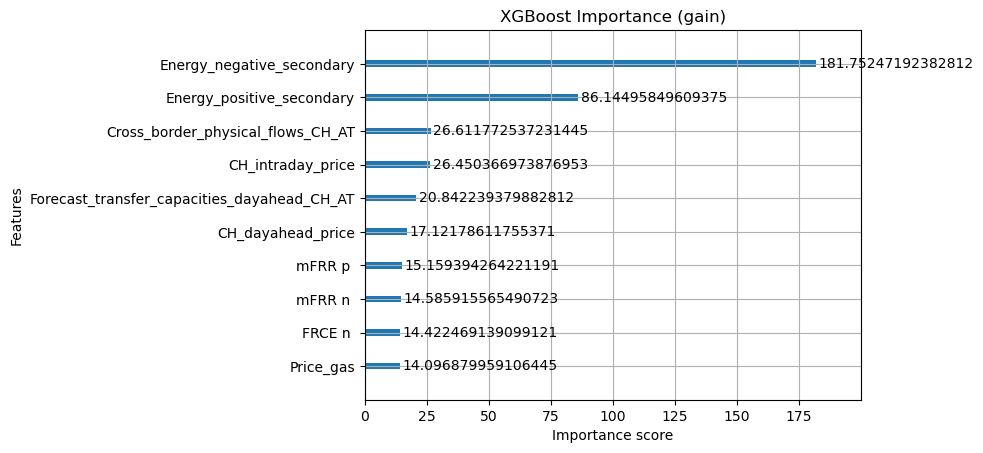

2) Permutation importances


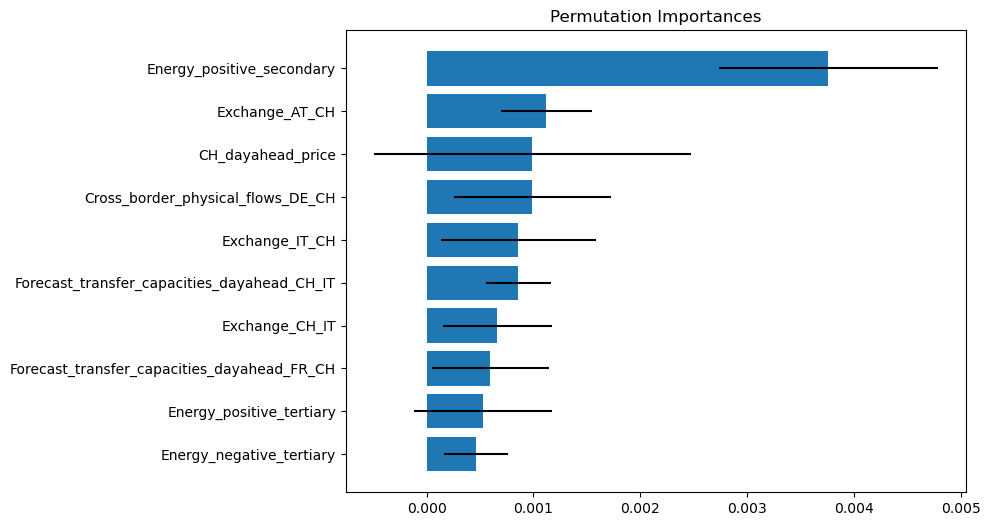

3) SHAP plots


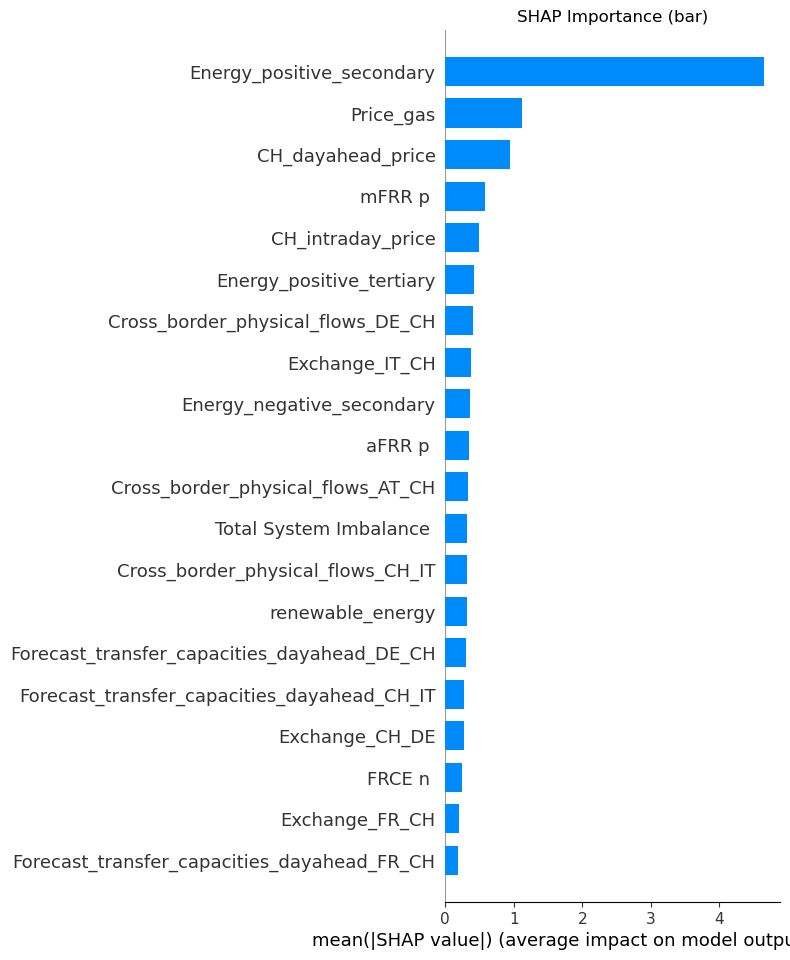

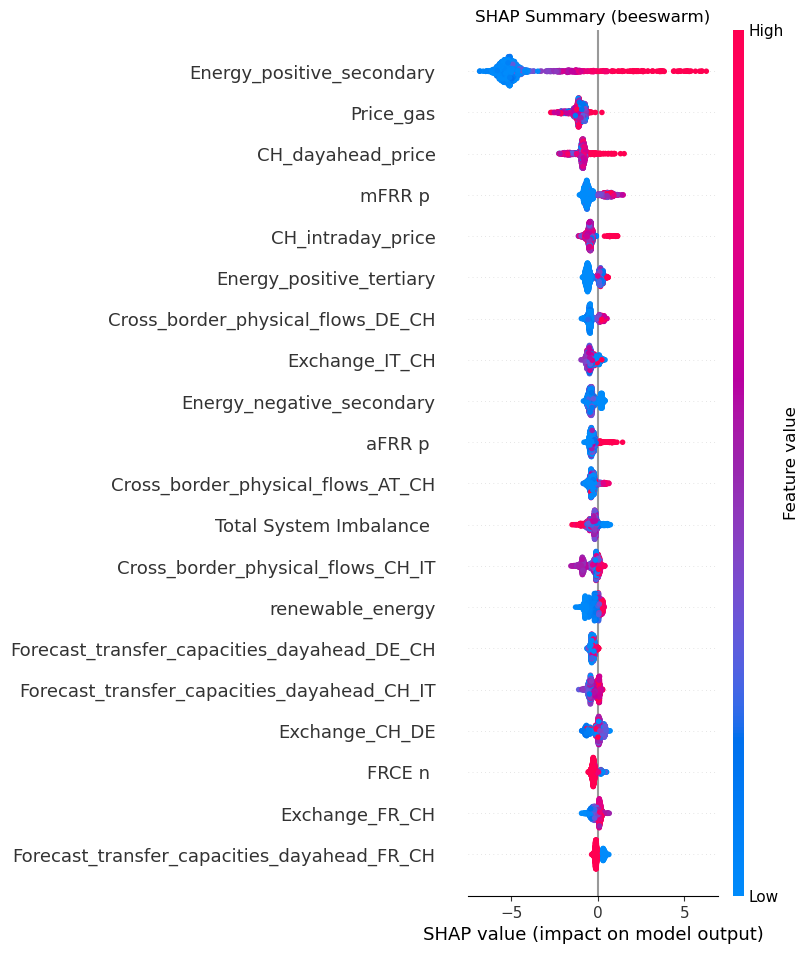

4) LIME explanation
LIME explanation (first instance):
  Energy_positive_secondary > 4.41: 0.0535
  CH_dayahead_price <= 89.36: -0.0082
  Total System Imbalance  > 103.48: -0.0075
  -56.00 < mFRR n  <= 0.00: 0.0072
  Cross_border_physical_flows_IT_CH <= 0.00: -0.0068
  31.60 < Price_gas <= 37.60: -0.0065
  Energy_positive_tertiary <= 0.00: -0.0064
  RR p  <= 0.00: 0.0060
  renewable_energy > 1065.00: 0.0055
  mFRR p  <= 0.00: -0.0053


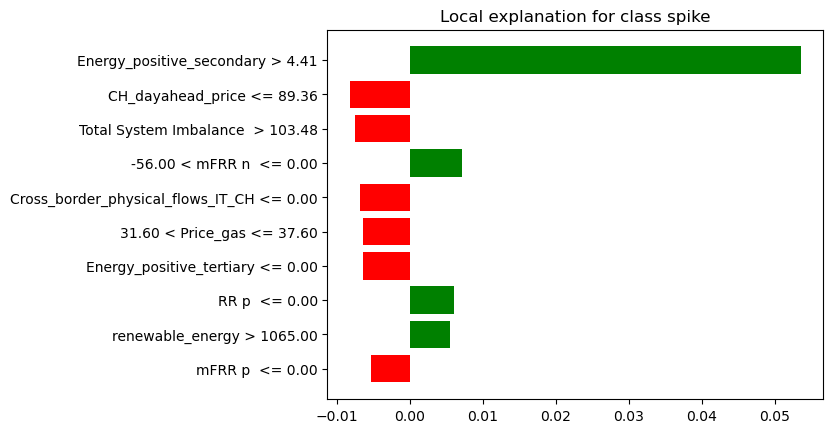

5) Precision–Recall


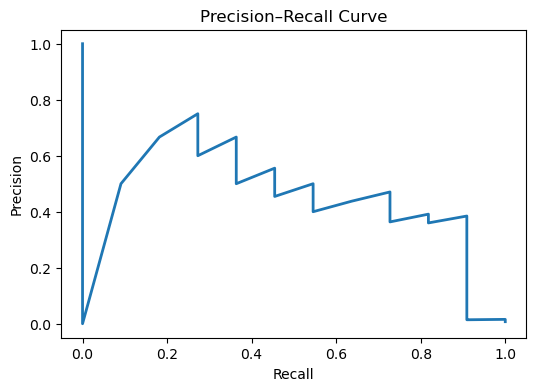

6) Economic profit:  4500

=== Evaluating Best Fold for Price_negative_secondary ===
1) Built‐in importance


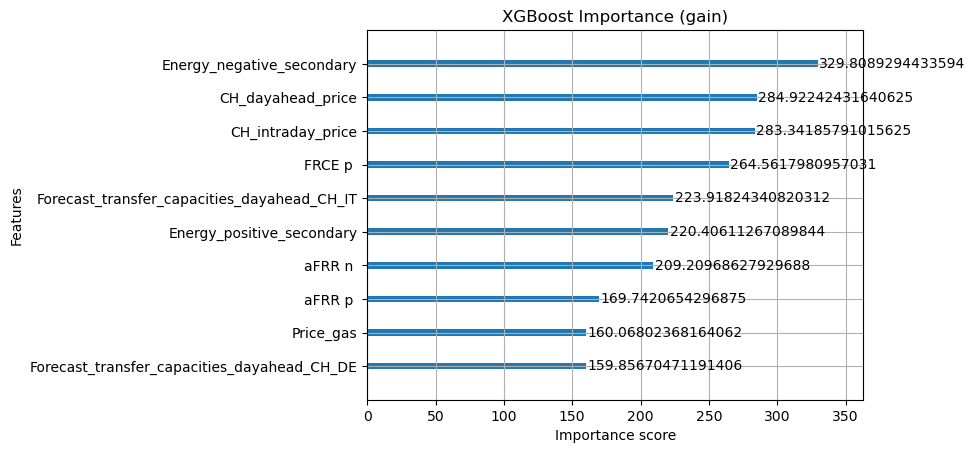

2) Permutation importances


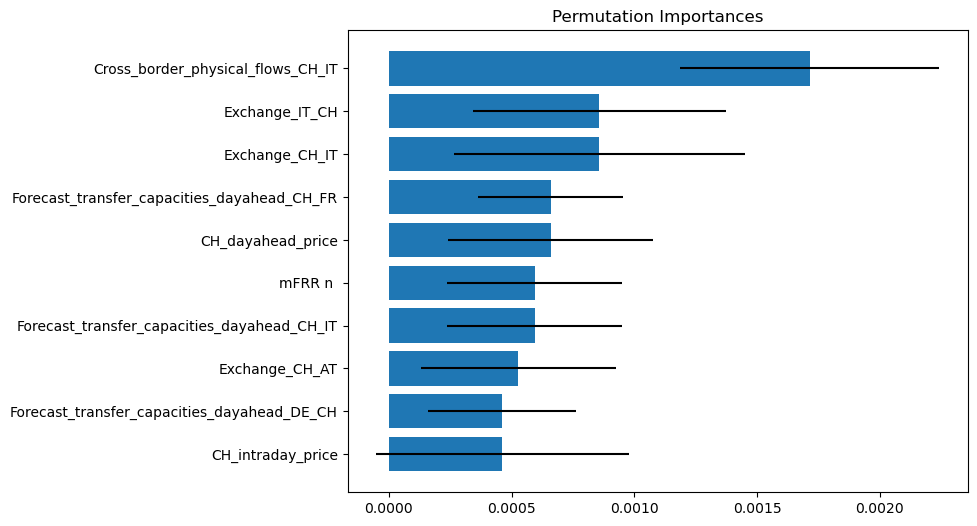

3) SHAP plots


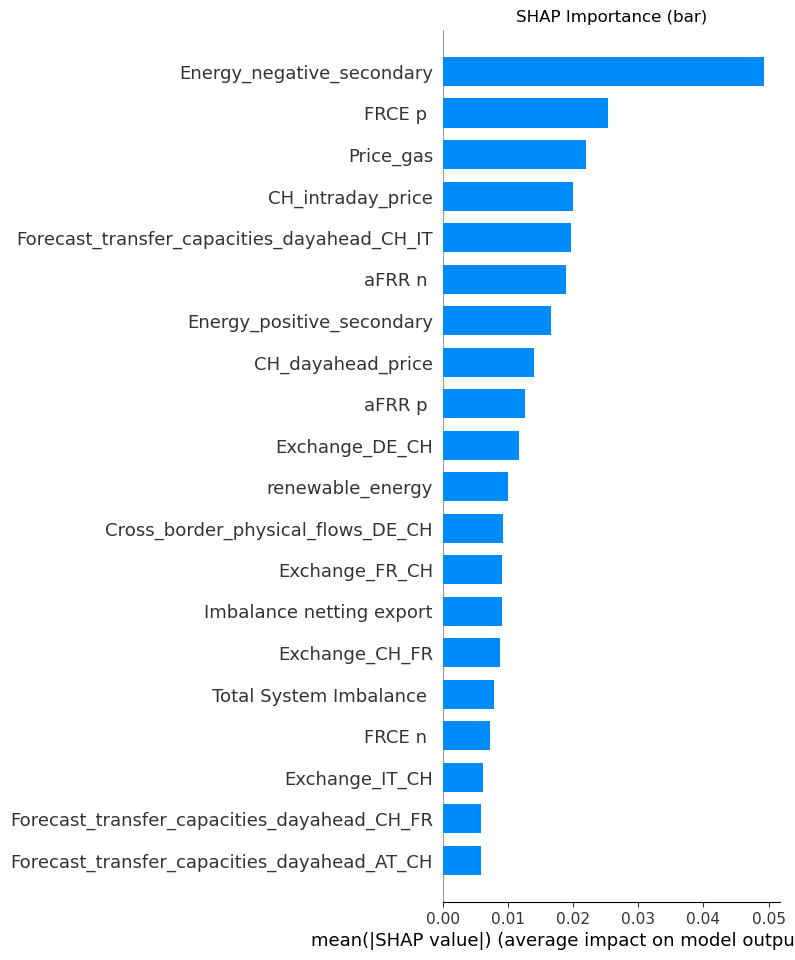

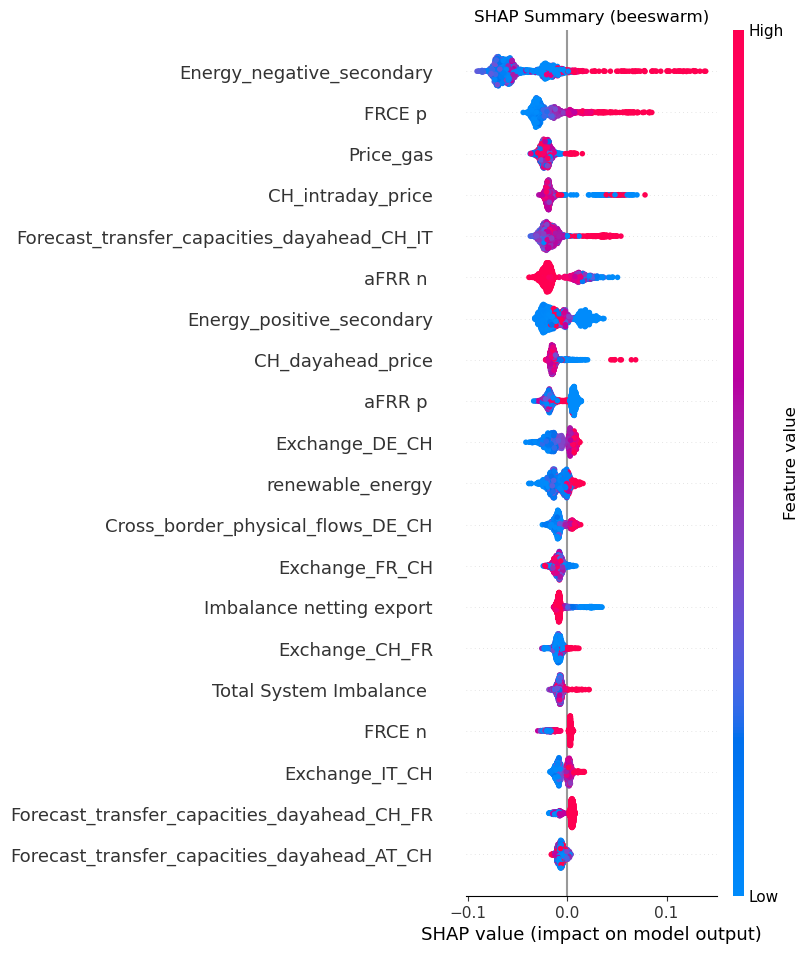

4) LIME explanation
LIME explanation (first instance):
  aFRR n  <= -15.59: 0.0088
  Forecast_transfer_capacities_dayahead_CH_FR <= 1161.00: -0.0059
  Energy_negative_secondary <= 0.30: 0.0055
  FRCE p  <= 0.00: -0.0048
  90.00 < CH_intraday_price <= 111.00: -0.0047
  aFRR p  <= 0.00: 0.0045
  Exchange_DE_CH <= 119.19: -0.0042
  Imbalance netting export <= -33.20: 0.0032
  31.60 < Price_gas <= 37.60: -0.0027
  1.22 < Exchange_IT_CH <= 14.60: -0.0025


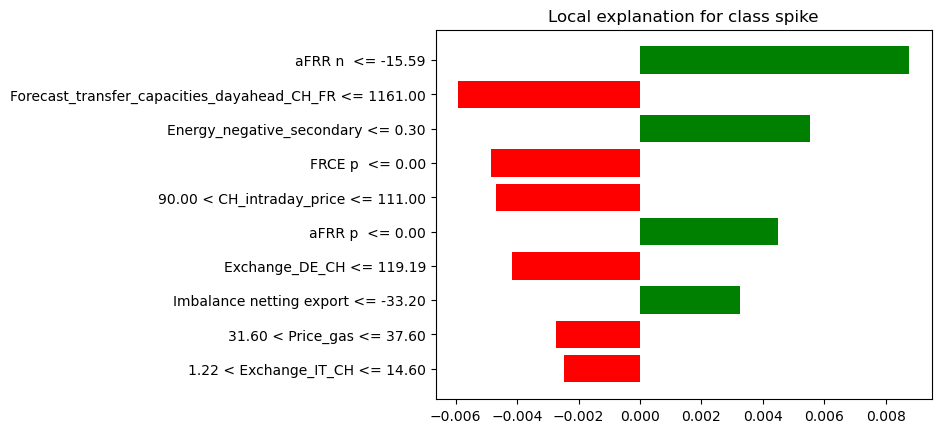

5) Precision–Recall


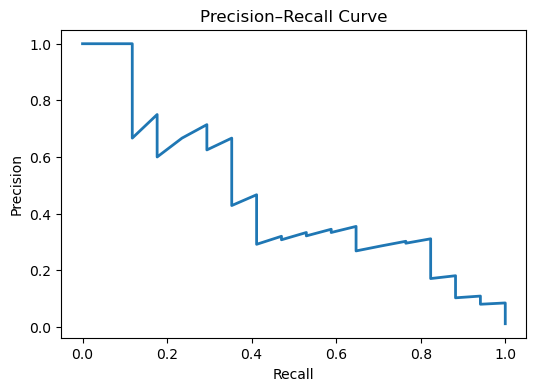

6) Economic profit:  6100

=== Evaluating Best Fold for Price_positive_tertiary ===
1) Built‐in importance


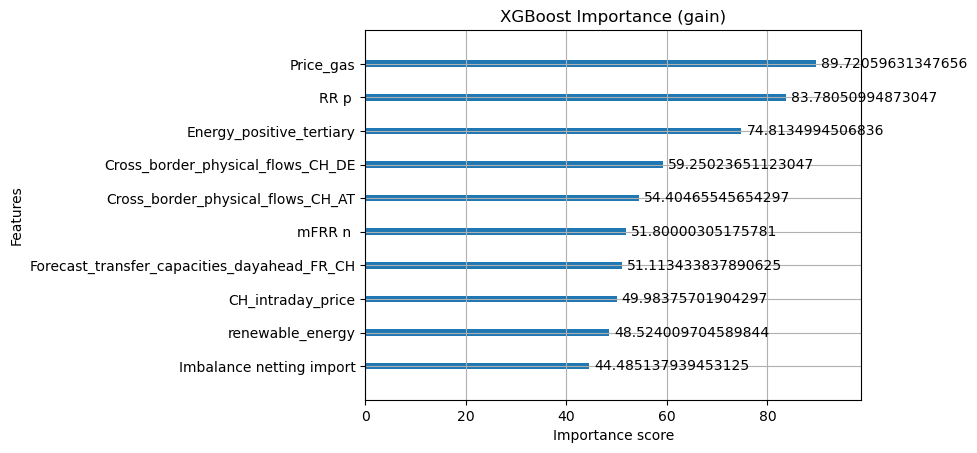

2) Permutation importances


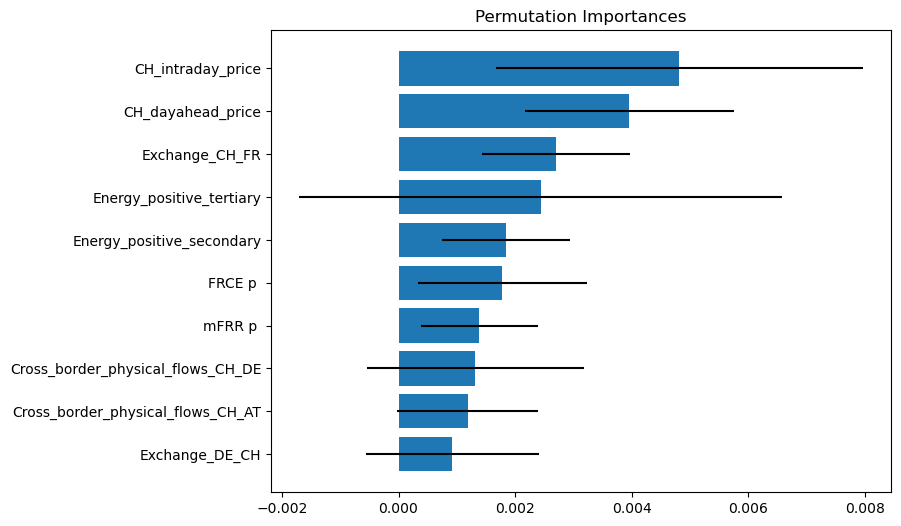

3) SHAP plots


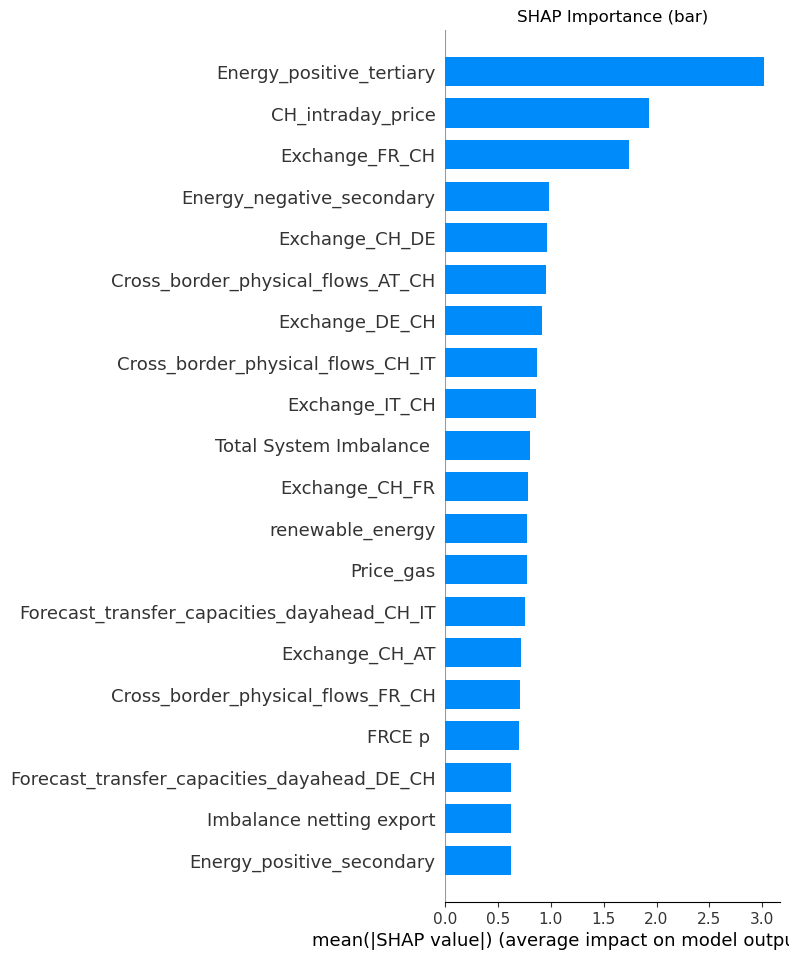

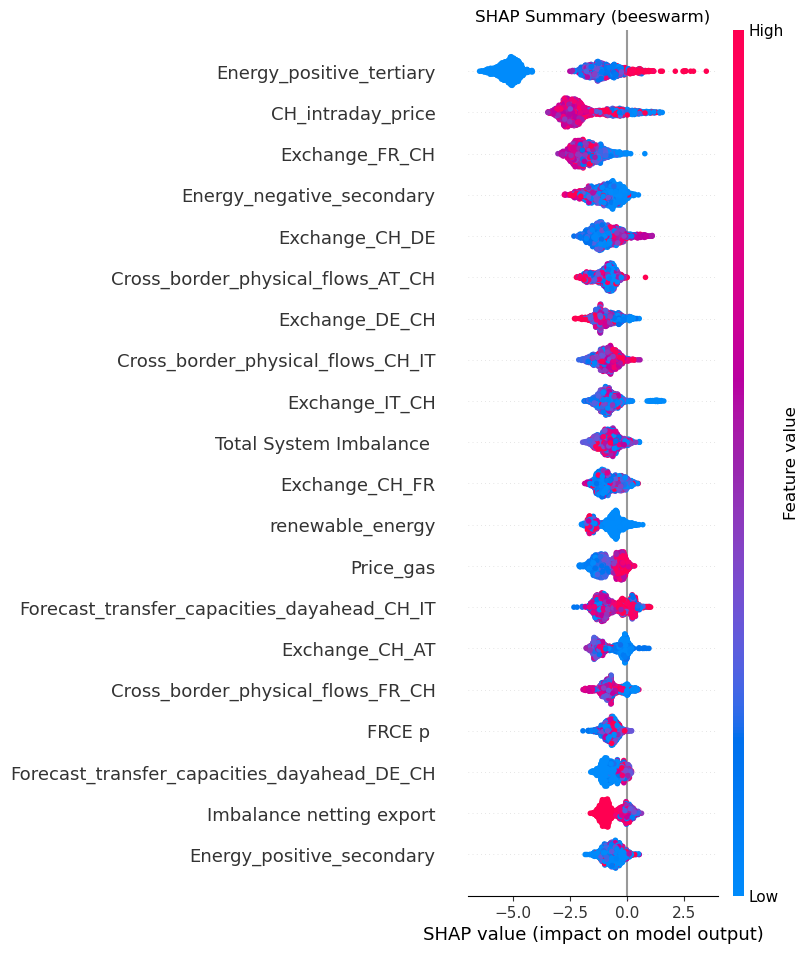

4) LIME explanation
LIME explanation (first instance):
  Energy_positive_tertiary <= 0.00: -0.1265
  108.75 < CH_intraday_price <= 135.10: -0.0388
  900.00 < Forecast_transfer_capacities_dayahead_CH_AT <= 1200.00: -0.0286
  Imbalance netting export <= -31.14: 0.0273
  Energy_negative_secondary > 11.67: -0.0226
  9.00 < Cross_border_physical_flows_AT_CH <= 413.00: -0.0217
  Cross_border_physical_flows_CH_AT <= 0.00: 0.0199
  1161.00 < Forecast_transfer_capacities_dayahead_CH_FR <= 1200.00: -0.0187
  Cross_border_physical_flows_DE_CH <= 0.00: -0.0184
  renewable_energy <= 231.00: 0.0175


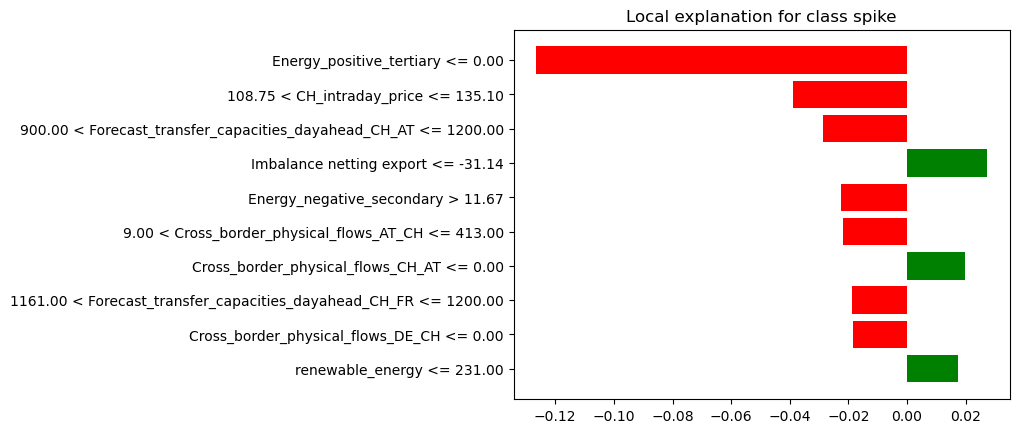

5) Precision–Recall


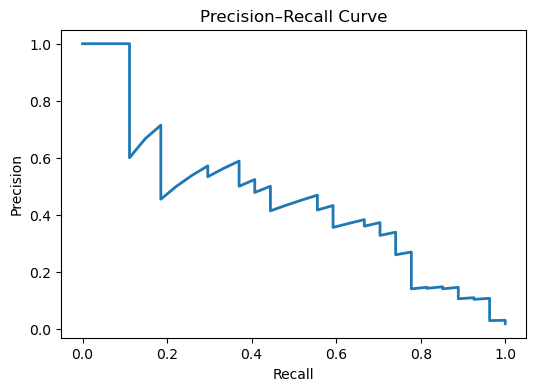

6) Economic profit:  14900

=== Evaluating Best Fold for Price_negative_tertiary ===
1) Built‐in importance


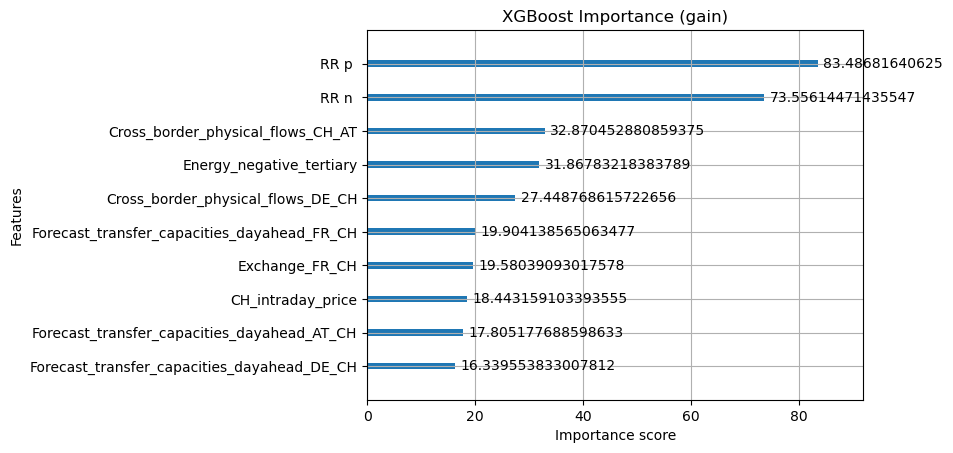

2) Permutation importances


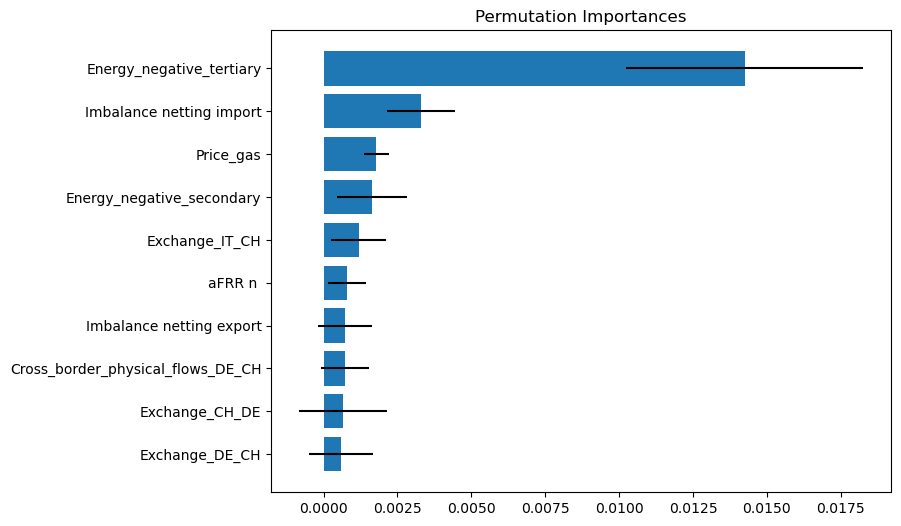

3) SHAP plots


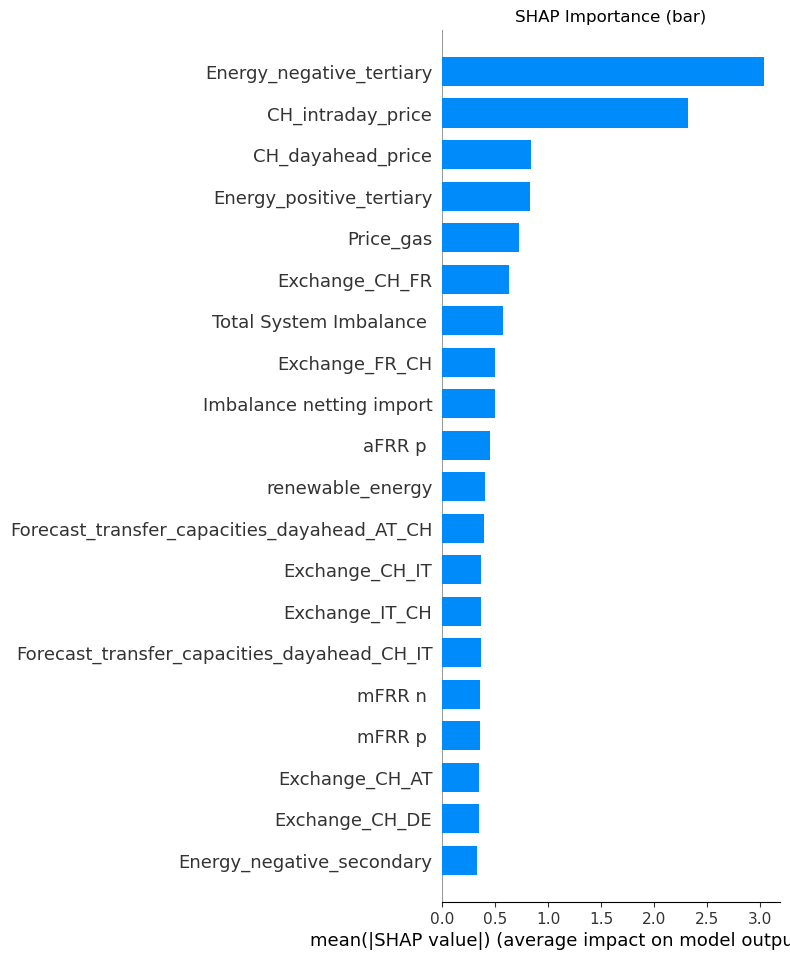

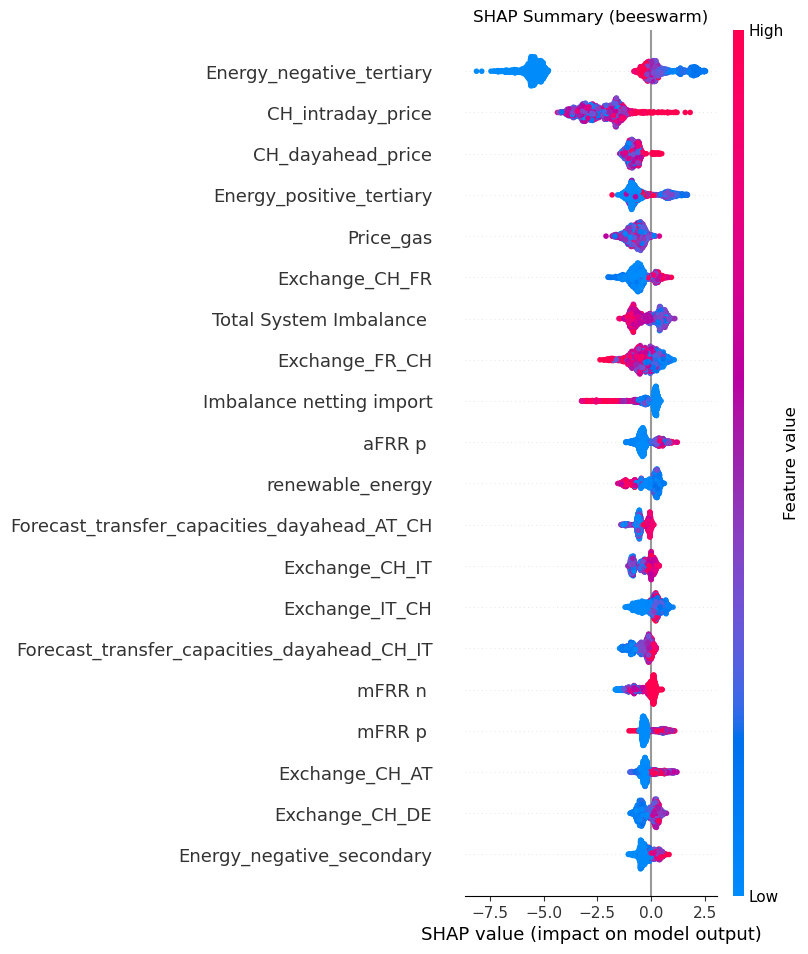

4) LIME explanation
LIME explanation (first instance):
  Energy_negative_tertiary <= 0.00: -0.1240
  142.57 < CH_intraday_price <= 156.45: -0.0535
  Exchange_CH_FR > 177.25: 0.0294
  Cross_border_physical_flows_IT_CH <= 0.00: 0.0269
  RR p  <= 0.00: 0.0245
  Total System Imbalance  > 100.23: -0.0223
  Imbalance netting import <= 0.00: 0.0202
  CH_dayahead_price <= 141.61: -0.0201
  -50.00 < mFRR n  <= 0.00: 0.0195
  Exchange_CH_IT <= 548.31: -0.0177


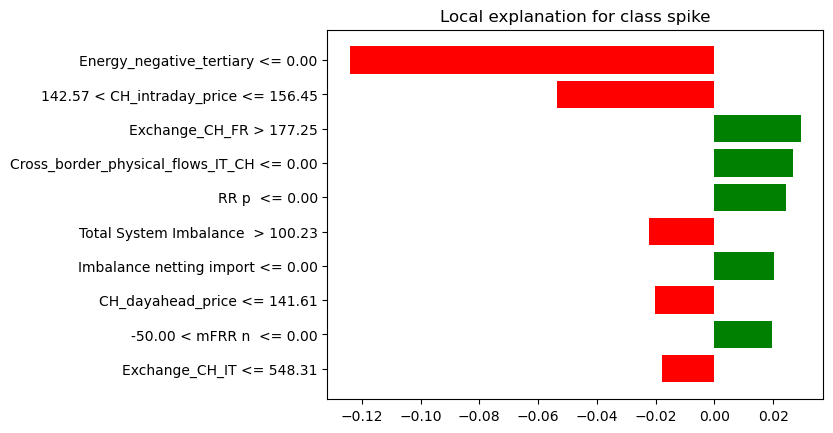

5) Precision–Recall


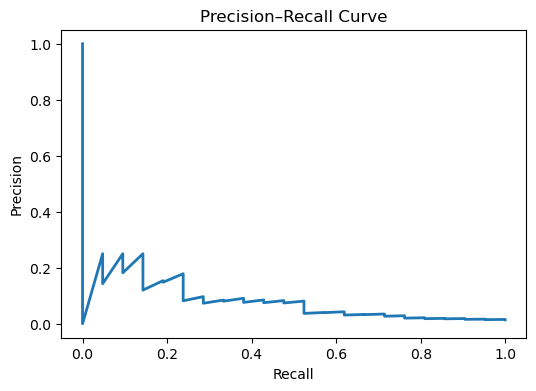

6) Economic profit:  1600


In [22]:
evaluate_all(best_folds)

# Save model

In [23]:
def save_xgb_models(best_folds, method="fixed", folder_name="my_models"):
    os.makedirs(folder_name, exist_ok=True)
    for target, fold in best_folds.items():
        safe_target = target.replace(" ", "_")
        filename = os.path.join(folder_name, f"{safe_target}_{method}.json")
        fold['model'].get_booster().save_model(filename)
        print(f"Saved model for '{target}' to {filename}")

def load_xgb_models(folder_name="my_models", method="fixed"):
    loaded_models = {}
    for fname in os.listdir(folder_name):
        if fname.endswith(f"_{method}.json"):
            target = fname.rsplit(f"_{method}.json", 1)[0]
            full_path = os.path.join(folder_name, fname)
            mdl = xgb.XGBClassifier()
            mdl.load_model(full_path)
            loaded_models[target] = mdl
            print(f"Loaded model for '{target}' from {full_path}")
    return loaded_models

In [24]:
save_xgb_models(best_folds, method=method, folder_name="ancillary_models")

Saved model for 'Price_positive_secondary' to ancillary_models\Price_positive_secondary_fixed.json
Saved model for 'Price_negative_secondary' to ancillary_models\Price_negative_secondary_fixed.json
Saved model for 'Price_positive_tertiary' to ancillary_models\Price_positive_tertiary_fixed.json
Saved model for 'Price_negative_tertiary' to ancillary_models\Price_negative_tertiary_fixed.json
